In [1]:
%%time
import sys;
import datetime
print('Starting at', datetime.datetime.now())
!{sys.executable} -m pip install -r requirements.txt
 

Starting at 2020-11-18 19:41:46.581139
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 64.2 ms, sys: 10.4 ms, total: 74.6 ms
Wall time: 2.31 s


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 795 ms, sys: 56.6 ms, total: 852 ms
Wall time: 2.88 s


In [3]:
%%time
import random
import pandas as pd
import pyarrow.parquet as pq

raw_data_filename = 'frauddetection.parquet.snappy'

s3 = boto3.resource('s3', region_name=region)
s3.Bucket(bucket).download_file('prepareddata/datapreparation_18Nov2020_1605714029944/datapreparation_18Nov2020_1605714029944_part00000.parquet.snappy',
                                raw_data_filename)
 

CPU times: user 1.86 s, sys: 582 ms, total: 2.44 s
Wall time: 2.55 s


In [4]:
table = pq.read_table(raw_data_filename)
df=table.to_pandas()
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print(len(df), 'Data items')

In [4]:
target_col='Fraudulent'

Length 2811841


In [5]:
df = df.rename(columns = {'isFraud': target_col,
                          'type_CASH_OUT': 'type_CashOut',
                          'type_TRANSFER': 'type_Transfer',
                          'oldbalanceOrg_nml': 'originOldBalance',
                          'oldBalanceOrigSign': 'originOldBalanceSign', 
                          'newbalanceOrig_nml': 'originNewBalance',
                          'negDeltaOrigin_nml': 'negativeDeltaInOrigin', 
                          'oldbalanceDest_nml': 'destinationOldBalance',
                          'newbalanceDest_nml': 'destinationNewBalance',
                          'expectedNewBalDest_nml': 'destinationExpectedNewBalance',#based on old value and delta   
                          'amount_nml': 'amount',
                         'hourOf24_radians': 'hourOf24_radians',# To be deleted after calculation
                          'isFlaggedFraud':'FlaggedFraud'#To be deleted

                         })


All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT`. Filter these out.

Counts of each class to determine imbalance.

In [6]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 8213 ; Not fraud 2803628 ; Total 2811841


Plot distribution of positive vs negative, in log scale because of the imbalance

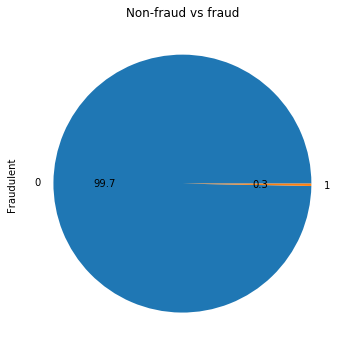

In [7]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
        df[target_col].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
    
plot_positive_negative_counts(df,target_col)

Check that target is on the left, per Sagemaker standard

In [8]:
cols = df.columns.tolist()
assert cols[0]==target_col

Transform hour of day to a form suited for cyclical data

In [9]:
import numpy as np
hours_col = 'hourOf24_radians'
df['sineHourInDay'] = np.sin(df[hours_col])
df['cosineHourInDay'] = np.cos(df[hours_col])
df = df.drop(hours_col, axis=1)
df

,Fraudulent,type_CashOut,type_Transfer,amount_nml,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,hour24sin,hour24cos
0,1,0,1,-0.354589,-0.191052,1,-0.111225,-0.190358,-0.402183,-0.440087,-0.436902,0.258626,0.965977
1,1,1,0,-0.354589,-0.191052,1,-0.111225,-0.190358,-0.397173,-0.435456,-0.436902,0.258626,0.965977
2,0,0,0,-0.348742,-0.024926,1,0.129430,-0.158648,-0.392274,-0.429800,-0.428269,0.258626,0.965977
3,0,0,0,-0.343859,-0.173919,1,-0.111225,-0.164015,-0.399618,-0.435647,-0.403098,0.258626,0.965977
4,0,1,0,-0.095013,-0.130487,1,-0.111225,-0.097235,-0.400981,-0.388926,-0.425880,0.258626,0.965977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811836,1,1,0,0.030321,1.166709,1,-0.111225,1.897298,-0.402183,-0.365872,-0.364218,-0.263246,0.964729
2811837,1,0,1,6.800773,25.049330,1,-0.111225,38.618570,-0.402183,0.939546,-0.436902,-0.263246,0.964729
2811838,1,1,0,6.800773,25.049330,1,-0.111225,38.618570,-0.385985,0.954518,0.928245,-0.263246,0.964729
2811839,1,0,1,0.608897,3.207624,1,-0.111225,5.035354,-0.402183,-0.254316,-0.436902,-0.263246,0.964729


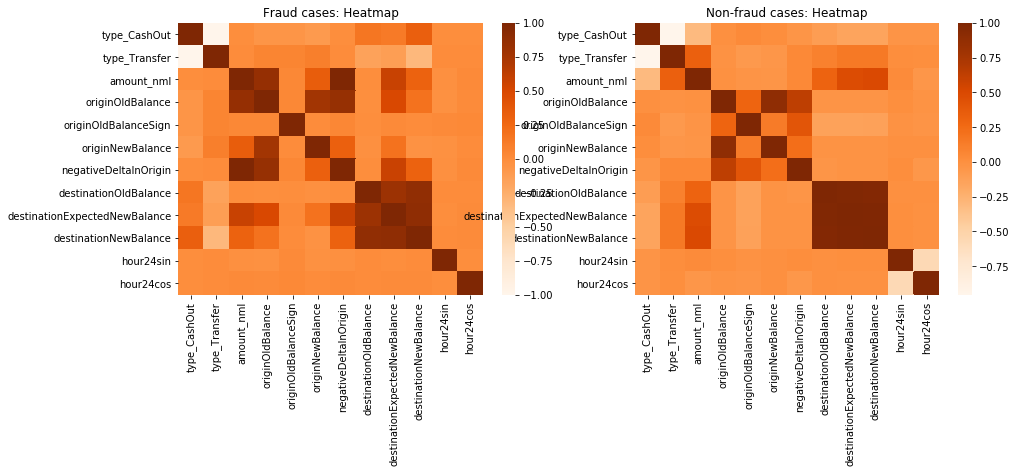

In [11]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl='Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'{target_col} == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [12]:
%%time 

from imblearn.over_sampling import SMOTENC

use_smote = False # Can just use weighting in XGBOOST instead of SMOTENC

if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 110 ms


# Split  with randomization

In [13]:
import numpy as np
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Using libSVM for performance.

In [ ]:
%%time
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region) 

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [ ]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

---
## Train

To train, first set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

import math

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
num_positive, num_negative=count_positive_and_negative(train_data)
scale_pos_weight=math.sqrt(num_negative / num_positive )
print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        gamma=4,
                        subsample=0.5,
                        eval_metric='aucpr',     
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=200, 
                        silent=0)

Run the `fit` training  or hypertuned-training job.

In [ ]:
%%time
hypertune = False
import pprint

if not hypertune:
    result = xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    training_job_name = xgb._current_job_name
else:
    import time

    from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
    hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


    objective_metric_name = 'validation:f1'

    tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, 
                            base_tuning_job_name='hypertune',
                            max_parallel_jobs=10)
    
    print('Starting hypertuning job')
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False, wait=False)
    print('Started hypertuning job', tuner.latest_tuning_job.job_name)

    counter = 0
    status = 'InProgress'
    while status == 'InProgress':
        tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
           HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
        counter += 0.5
        time.sleep(30)   
        status = tuning_job_result['HyperParameterTuningJobStatus']
        print(f'{counter} min., {status};', end=' ')
        
    if 'BestTrainingJob' in tuning_job_result:
       training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
    else:
       raise Exception(f'No best job identified {tuning_job_result}')


---
## Host

Deploy the trained model to an endpoint.

In [ ]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
model_name = training_job_name + '-model'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


date_sfx = 

endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + date_sfx,
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True
while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{counter} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
counter = 0 
while endpt_status in ['Updating', 'Creating']:
    counter += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{counter} min: {endpt_status} endpoint; ',end='')
    time.sleep(30)

print('Finished creating or updating endpoint')

xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name, sagemaker_session=sagemaker.Session())

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [ ]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float(num) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

In [ ]:
actual_pos = sum(1 for i in range(len(labels)) if 1 == labels[i])
actual_neg = sum(1 for i in range(len(labels)) if 0 == labels[i])

pred_pos = sum(1 for i in range(len(preds)) if 1 == preds[i])
pred_neg = sum(1 for i in range(len(preds)) if 0 == preds[i])

true_pos = sum(1 for i in range(len(preds)) if preds[i] == 1 == labels[i])
true_neg = sum(1 for i in range(len(preds)) if preds[i] == 0 == labels[i])

false_pos=sum(1 for i in range(len(preds)) if preds[i] == 1 and 0 == labels[i])
false_neg=sum(1 for i in range(len(preds)) if preds[i] == 0 and 1 == labels[i])

recall = true_pos / (true_pos + false_neg)
precision = true_pos / (true_pos + false_pos)
f1 = (2 * precision * recall) / (precision + recall)
error = sum(1 for i in range(len(preds)) if preds[i] != labels[i]) / float(len(preds))

assert recall <= f1 <= precision or precision <= f1 <= recall 
assert true_pos + false_neg == actual_pos
assert true_neg + false_pos == actual_neg
#print('pred_pos', pred_pos,'pred_neg', pred_neg)

assert len(preds)==len(labels)

#print(len(preds), 'predictions and labels')

#print('actual_pos', actual_pos, 'actual_neg', actual_neg)
assert actual_pos + actual_neg==len(labels)
                   
#print('true_pos', true_pos, 'false_pos', false_pos)
#assert  true_pos+false_pos == pred_pos

#print('true_neg', true_neg, 'false_neg', false_neg )
assert true_neg + false_neg== pred_neg

#print('pred_pos+pred_neg',pred_pos+pred_neg)
assert pred_pos + pred_neg==len(preds)

print(f'Recall = {recall:.2f}')
print(f'Precision = {precision:.2f}')
print(f'Error rate = {error:.2f}')
print(f'F1 = {f1:.2f}')

Show confusion matrix.

In [ ]:
 
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['actual fraud'],  colnames=['predicted as fraud'])

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)